In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
raw_data = pd.read_csv('Breast_cancer_dataset.csv')
df = raw_data.copy()

In [3]:
df['diagnosis_mapped'] = df['diagnosis'].map({'M':1, 'B': 0})
diagnosis_ = df[['diagnosis']]
df.drop('Unnamed: 32', inplace = True, axis =1)
df = df.set_index('id')

corr = df.corr(numeric_only=True)
corr_target = df.corr(numeric_only=True)['diagnosis_mapped'].sort_values(ascending=False)

In [4]:
X = df.drop(columns=['diagnosis_mapped', 'diagnosis'])
vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [5]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X_reduced = X.drop(columns=to_drop)

In [6]:
vif_ = pd.DataFrame()
vif_['feature'] = X_reduced.columns
vif_['VIF'] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

In [7]:
pca = PCA(n_components=0.95)  # keep 95% variance
X_pca = pca.fit_transform(X_reduced)

In [8]:
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

vif_pca = pd.DataFrame()
vif_pca['feature'] = X_pca_df.columns
vif_pca['VIF'] = [variance_inflation_factor(X_pca_df.values, i) for i in range(X_pca_df.shape[1])]

print(vif_pca)

  feature  VIF
0     PC1  1.0
1     PC2  1.0


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pca, df['diagnosis_mapped'], test_size=0.2, random_state=42)

# Train logistic regression
logreg = LogisticRegression(max_iter=1000, class_weight={0:1, 1:3})
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        71
           1       0.80      0.93      0.86        43

    accuracy                           0.89       114
   macro avg       0.88      0.89      0.88       114
weighted avg       0.90      0.89      0.89       114

[[61 10]
 [ 3 40]]


In [10]:
y_probs = logreg.predict_proba(X_test)[:,1]  # probabilities for class 1

# Set a lower threshold to increase recall
threshold = 0.3
y_pred_adj = (y_probs >= threshold).astype(int)

print(classification_report(y_test, y_pred_adj))


              precision    recall  f1-score   support

           0       1.00      0.69      0.82        71
           1       0.66      1.00      0.80        43

    accuracy                           0.81       114
   macro avg       0.83      0.85      0.81       114
weighted avg       0.87      0.81      0.81       114



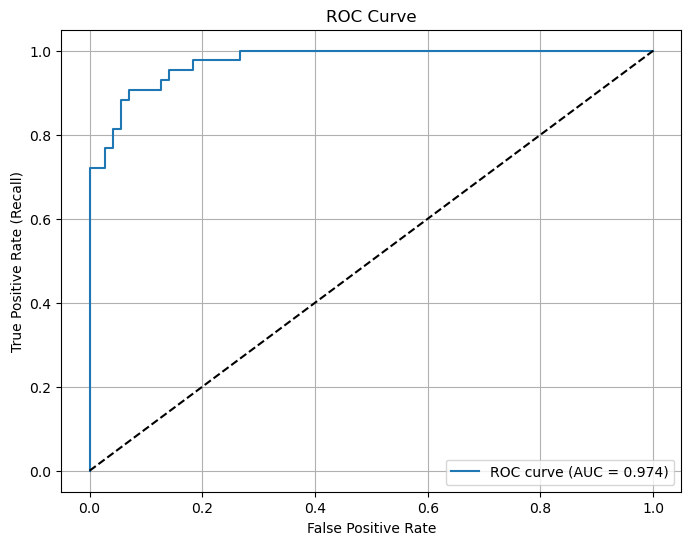

In [11]:
y_probs = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


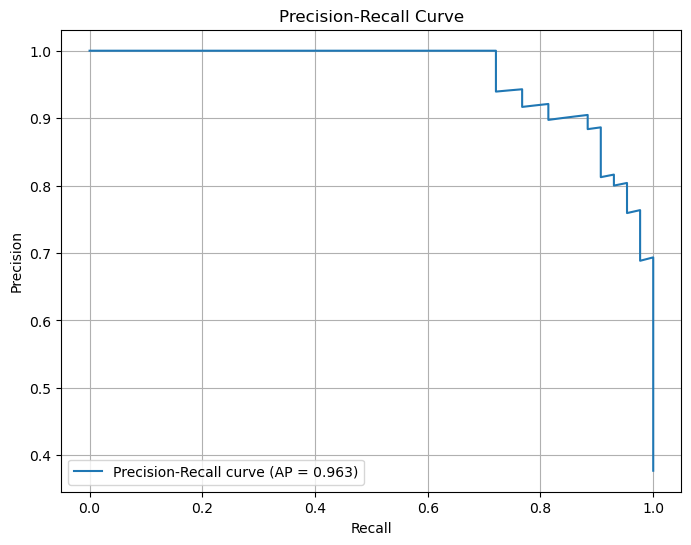

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [13]:
y_pred_series = pd.Series(y_pred, index=y_test.index)
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_series, 'Adj_Predict': y_pred_adj})

In [14]:
results.head(100)

,Actual,Predicted,Adj_Predict
id,,,
87930,0,0,0
859575,1,1,1
8670,1,1,1
907915,0,0,0
921385,0,0,0
...,...,...,...
864033,0,0,0
926682,1,1,1
87880,1,1,1
